# Malaria Classification - Image Classification

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Preparing the data

In [3]:
dataset, dataset_set = tfds.load('malaria', split=['train'], as_supervised=True, shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteKARHSR/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for data in dataset[0].take(4):
  print(data)

In [8]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

In [15]:
DATASET_SIZE = len(dataset[0])

train_dataset = dataset[0].take(int(TRAIN_RATIO*DATASET_SIZE))

val_dataset = dataset[0].skip(int(TRAIN_RATIO*DATASET_SIZE)) # skips upto 80%
val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE)) # then takes the 10% of the remaining 20% as validation dataset

test_dataset = dataset[0].skip(int((TRAIN_RATIO+VAL_RATIO)*DATASET_SIZE)) # skips upto 90%
test_dataset = test_dataset.take(int(TEST_RATIO*DATASET_SIZE)) # then takes the 10% as test data

In [16]:
print(len(train_dataset))
print(len(val_dataset))
print(len(val_dataset))

22046
2755
2755


In [23]:
print(list(train_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


## Visualising the Dataset

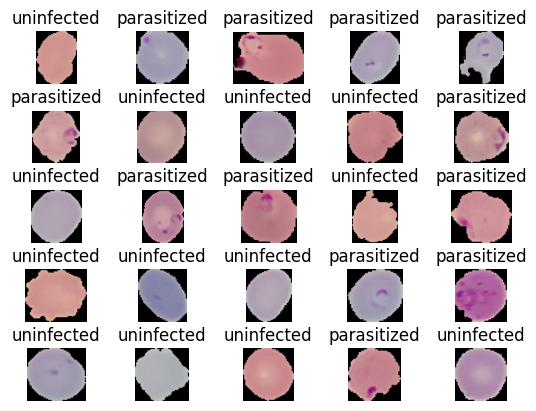

In [33]:
fig = plt.figure()

for i, (image, label) in enumerate(train_dataset.take(25)):
  plt.subplot(5,5, i+1)
  plt.imshow(image)
  plt.title(dataset_set.features['label'].int2str(label))
  plt.axis('off')

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

## Data Preprocessing

Normalisation
$$X = \frac{X - X(min)}{X(max) - X(min)}$$

i.e

$$
  X = \frac{X - 0}{255-0}\\
  X = \frac{X}{255}
$$

